<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/StatsUnit2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the game Mario Maker 2, players are given the ability to design their own Mario levels and share them online. Each level can be styled after either the original Super Mario Bros., Super Mario Bros. 3, Super Mario World, New Super Mario Bros. U, or Super Mario 3D World. This model will attempt to predict the true likelihood of a player making a New Super Mario Bros. U level.

New Super Mario Bros. U may be shortened to NSMBU.

In [1]:
#Install and import datasets and preliz libraries
!pip install datasets
from datasets import load_dataset

!pip install preliz
import preliz as pz

In [8]:
#Import other libraries
import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import random as rd

There are five available game styles for players to choose from. The styles based on later entries in the Super Mario Bros. series tend to have more features than the older ones, and they have a more three-dimensional look to them than the 8 or 16 bit options. Being a later entry, I believe New Super Mario Bros. U will be a more interesting option to players than the other styles. I think the true probability of a player choosing NSMBU as a game style will be slightly higher than one in five at 3/10. My prior will be a beta distribution centered on 3/10.

mean: 0.3
median: 0.2862366680304244
mode: 0.25


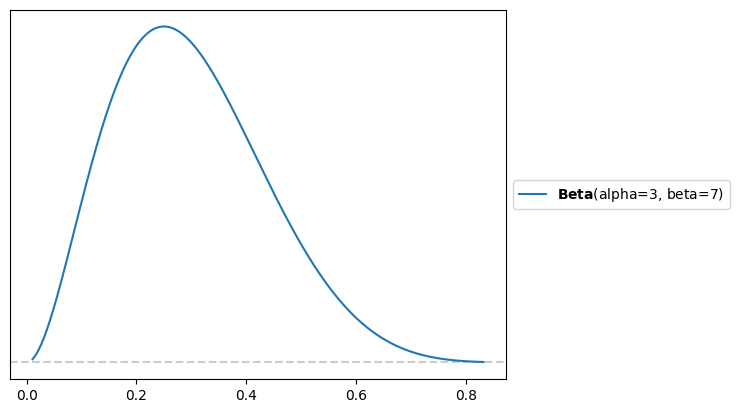

In [3]:
#Define prior probability density function
prior_pdf = pz.Beta(alpha=3,beta=7)
#Get mean, median, and mode
prior_mean = prior_pdf.mean()
prior_median = prior_pdf.median()
prior_mode = (prior_pdf.alpha - 1) / (prior_pdf.alpha + prior_pdf.beta - 2)

#Plot the prior and its mean, median, and mode
prior_pdf.plot_pdf()
print("mean: " + str(prior_mean))
print("median: " + str(prior_median))
print("mode: " + str(prior_mode))

The Mario Maker 2 data used for this project was acquired from https://huggingface.co/datasets/TheGreatRambler/mm2_level. The dataset contains a variety of information about player uploaded levels, including the game style. The styles are denoted with numbers 0 through 4 such that:

0 is Super Mario Bros.

1 is Super Mario Bros. 3

2 is Super Mario World

3 is New Super Mario Bros. U

4 is Super Mario 3D World

The dataset is too large to load quickly in its entirety, so it is loaded in streaming mode, which means only part of the dataset is loaded at a time. 1000 entries of level data are acquired and shuffled, before it is recorded in a numpy array whether they are NSMBU levels.

In [9]:
#Read Mario Maker data
mario_levels = load_dataset("TheGreatRambler/mm2_level", streaming=True, split="train")
#Shuffle data
shuffled_levels = mario_levels.shuffle(buffer_size=1_000, seed=rd.randint(0,100))
#Get the data as a list to iterate over
sample = list(shuffled_levels.take(1000))
#Create a zeroed numpy array matching the size of the list
nsmbu = np.zeros(1000)
#For each element of the list, record any NSMBU levels with a one in the Numpy array
for i in range(0, 1000):
  if((sample[i]["gamestyle"]) == 3):
    nsmbu[i] = 1
#Display the Numpy array
nsmbu

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

array([1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

The pymc model will be created based on the previously explained prior and likelihood. 1000 samples will be drawn from the model and the plotted.

<Axes: title={'center': 'θ'}>

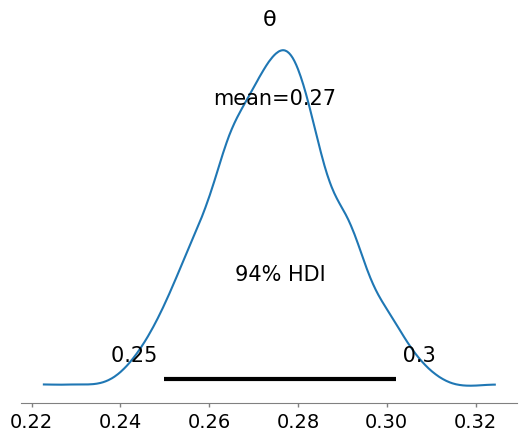

In [6]:
#Create Mario Maker style model
with pm.Model() as mm_style_model:
  #Define a prior beta distribution as described above
  θ = pm.Beta('θ', alpha = 3., beta = 7.)

  #Define the likelihood using the prior and the previously collected level data
  y = pm.Bernoulli('y', p = θ, observed = nsmbu)

  #Sample from the posterior model
  idata_style = pm.sample(1000)

#vizualize the 1000 samples from the pymc model of the posterior
az.plot_posterior(idata_style)

The mean produced by the posterior prediction was 0.27, representing a 27% chance of the next created Mario Maker 2 level being made in the New Super Mario Bros. U style. This is less than the mean of my prior, 0.3, so the model predicts NSMBU levels to be less likely than I had assumed. However, .27 is still greater than .2, or 1/5, as would be expected if all five level styles were equally likely to be picked.

In [12]:
#Use the posterior samples and the model to predict future level styles
pm.sample_posterior_predictive(idata_style, model=mm_style_model, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data